In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import re
from copy import deepcopy
from sklearn.decomposition import PCA
from numpy import savetxt, loadtxt
from scipy.stats import ranksums,mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import graphviz
from scipy.stats import rankdata,spearmanr,pearsonr
from sklearn.linear_model import LogisticRegression
from scipy.special import logit
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed

In [2]:
from matplotlib import style
import seaborn as sns
import statsmodels.formula.api as smf

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [3]:
def pie(df, col, numerical=False, label_dict=None):
    val_lst = list(df[col])
    if numerical:
        try:
            temp = [int(x) for x in val_lst if x not in ["'--","Unknown",'Not Reported','not reported',np.nan]]
        except:
            temp = [float(x) for x in val_lst if x not in ["'--","Unknown",'Not Reported','not reported',np.nan]]
        val_lst = temp+(len(val_lst)-len(temp))*[np.nan]
        labels = sorted(set(val_lst))
    else:
        labels = sorted(set(val_lst))
    sizes = []
    for l in labels:
        sizes.append(val_lst.count(l))
    plt.figure(figsize=(10,10))
    if label_dict is not None:
        labels = [label_dict[l] for l in labels]
    plt.pie(x=sizes, labels=labels, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(sizes)/100))


In [4]:
def add_gene_names(table):
    table['ENSG'] = [x[:x.find('.')] for x in table.index]
    table = pd.merge(table,target_list_symbols,how='left',left_on='ENSG',right_index=True)
    table = table[['external_gene_name']+list(table.columns[:-1])]
    table = table.drop('ENSG', axis=1)
    return table

In [8]:
# Load clinical data
filepaths = ['../data/clinical/'+x for x in ['clinical.tsv','exposure.tsv','family_history.tsv']]
clinical = pd.DataFrame()
for filepath in filepaths:
    clinical = clinical.merge(pd.read_table(filepath, index_col=0), left_index=True, right_index=True, how='outer')
    
# Remove duplicated rows
clinical = clinical.drop_duplicates()

# Remove columns with information for less than 50% of the cases
missing_value_cutoff = 0.7  # initial threshold, there's a finer threshold later

cols_to_keep = [x for x in list(clinical) if (
    len([y for y in clinical.loc[:,x] if y not in ["'--","Unknown",'Not Reported','not reported',np.nan]])>=
    (1-missing_value_cutoff)*len(clinical))]
#if 'race' not in cols_to_keep:
#    cols_to_keep.append('race')
#if 'treatment_type' not in cols_to_keep:
#    cols_to_keep.append('treatment_type')       
    
clinical = clinical.loc[:,cols_to_keep]

clinical = clinical.drop_duplicates()

# Remove cases with no information about smoking habits
#clinical = clinical[clinical['tobacco_smoking_status']!=7]

clinical

,case_submitter_id_x,project_id_x,days_to_birth,...,tobacco_smoking_status,weight,years_smoked
case_id,,,,,,,
006931bb-f5b1-4aa4-b0a8-af517a912db0,C3L-01838,CPTAC-3,-25663,...,3,81.0,33.0
0449aa40-ee66-45c5-baa7-db48dbcc7702,C3L-02163,CPTAC-3,-21020,...,2,74.0,22.0
061b9248-7ef1-47f1-9893-9958451ad9ab,C3L-02629,CPTAC-3,-21143,...,3,98.0,'--
07057080-464f-455d-a267-2301c721ded2,C3L-00412,CPTAC-3,-23597,...,4,84.0,46.0
070f4283-176a-492e-b418-ebf292cd37d6,C3L-00893,CPTAC-3,-26209,...,3,86.818,40.0
...,...,...,...,...,...,...,...
f82aacd5-6e2b-41c4-96a7-af723d874d8c,C3N-01414,CPTAC-3,-21232,...,1,50.0,'--
f8614e58-809d-4496-a54e-8f1a1303c202,C3L-02646,CPTAC-3,-27321,...,2,95.0,4.0
f8f3df64-54c1-4d1a-8ea7-c371b01c2ef6,C3L-02627,CPTAC-3,-23667,...,2,70.0,32.0


In [237]:
'''
filepaths = ['../data/clinical/'+x for x in ['clinical.tsv','exposure.tsv','family_history.tsv']]
clinical = pd.DataFrame()
for filepath in filepaths:
    clinical = clinical.merge(pd.read_table(filepath, index_col=0), left_index=True, right_index=True, how='outer')
    
clinical1 = clinical.loc[samples3['case_id'],:]
clinical1
'''

"\nfilepaths = ['../../data/causal_inference_project/clinical/'+x for x in ['clinical.tsv','exposure.tsv','family_history.tsv']]\nclinical = pd.DataFrame()\nfor filepath in filepaths:\n    clinical = clinical.merge(pd.read_table(filepath, index_col=0), left_index=True, right_index=True, how='outer')\n    \nclinical1 = clinical.loc[samples3['case_id'],:]\nclinical1\n"

In [238]:
'''
col = 'treatment_type'
temp = clinical.groupby('case_id')[col].apply(list)
for case in temp.index:
    if len(temp[case])>1:
        print(temp[case])
        #if len(set(temp[case]))==1:
        #    clinical[clinical['case_id']==]
# Remove duplicated rows
#clinical = clinical.drop_duplicates()


pie(clinical1,'treatment_type')
pie(clinical1,'race')
'''

"\ncol = 'treatment_type'\ntemp = clinical.groupby('case_id')[col].apply(list)\nfor case in temp.index:\n    if len(temp[case])>1:\n        print(temp[case])\n        #if len(set(temp[case]))==1:\n        #    clinical[clinical['case_id']==]\n# Remove duplicated rows\n#clinical = clinical.drop_duplicates()\n\n\npie(clinical1,'treatment_type')\npie(clinical1,'race')\n"

In [240]:
'''
# Look at duplicated rows
for case in set(clinical.index):
    if len([c for c in clinical.index if c==case])>1:
        print('\n', case, len(clinical.loc[case,:]))
        case_df = clinical.loc[case,:]
        for col in list(clinical):
            if len(set(case_df[col]))>1:
                print(col, set(case_df[col]))
'''

"\n# Look at duplicated rows\nfor case in set(clinical.index):\n    if len([c for c in clinical.index if c==case])>1:\n        print('\n', case, len(clinical.loc[case,:]))\n        case_df = clinical.loc[case,:]\n        for col in list(clinical):\n            if len(set(case_df[col]))>1:\n                print(col, set(case_df[col]))\n"

In [242]:
# Load table of samples
'''
filepath = '../data/biospecimen/sample.tsv'
samples = pd.read_table(filepath)

# Remove columns with no information
samples = samples.loc[:,[x for x in list(samples) if (
    not set(samples.loc[:,x]).issubset(set(["'--","Unknown",'Not Reported','not reported',np.nan])) )]]

# only keep samples from solid tissue (filter out blood samples, '3D Organoid', etc.)
samples = samples[samples.loc[:,'composition']=='Solid Tissue']

print(len(set(samples['case_id'])), 'patients,', len(samples), 'samples')
samples
'''

'\nfilepath = \'../../data/causal_inference_project/biospecimen/sample.tsv\'\nsamples = pd.read_table(filepath)\n\n# Remove columns with no information\nsamples = samples.loc[:,[x for x in list(samples) if (\n    not set(samples.loc[:,x]).issubset(set(["\'--","Unknown",\'Not Reported\',\'not reported\',np.nan])) )]]\n\n# only keep samples from solid tissue (filter out blood samples, \'3D Organoid\', etc.)\nsamples = samples[samples.loc[:,\'composition\']==\'Solid Tissue\']\n\nprint(len(set(samples[\'case_id\'])), \'patients,\', len(samples), \'samples\')\nsamples\n'

In [243]:
'''
filepath = '../data/biospecimen/aliquot.tsv'
table = pd.read_table(filepath)

# Remove columns with no information
table = table.loc[:,[x for x in list(table) if (
    not set(table.loc[:,x]).issubset(set(["'--","Unknown",'Not Reported','not reported',np.nan])) )]]

list(table)
table
'''

'\nfilepath = \'../../data/causal_inference_project/biospecimen/aliquot.tsv\'\ntable = pd.read_table(filepath)\n\n# Remove columns with no information\ntable = table.loc[:,[x for x in list(table) if (\n    not set(table.loc[:,x]).issubset(set(["\'--","Unknown",\'Not Reported\',\'not reported\',np.nan])) )]]\n\nlist(table)\ntable\n'

In [244]:
'''
for col in list(table):
    if set(manifest['id']).intersection(set(table[col])):
        print(col)
    if set(files['file_name']).intersection(set(table[col])):
        print(col)
    if set([x[:x.find('.')] for x in files['file_name']]).intersection(set(table[col])):
        print(col)
'''

"\nfor col in list(table):\n    if set(manifest['id']).intersection(set(table[col])):\n        print(col)\n    if set(files['file_name']).intersection(set(table[col])):\n        print(col)\n    if set([x[:x.find('.')] for x in files['file_name']]).intersection(set(table[col])):\n        print(col)\n"

In [245]:
#patient_lst = list(set(samples['case_id']).intersection(set(clinical.index)))
#print(len(patient_lst), 'patients with at least one sample')

In [246]:
#samples = samples.loc[[x for x in samples.index if samples.loc[x,'case_id'] in patient_lst],:]
#print(len(samples), 'relevant samples')

In [247]:
# Load file list
filelst = '../data/399_files_STAR_counts/files.2021-02-23.json'
files = pd.read_json(filelst)

# Arrage the case_id, project_id columns
files['case_id'] = [files.loc[i,'cases'][0]['case_id'] for i in files.index]
files['project_id'] = [files.loc[i,'cases'][0]['project']['project_id'] for i in files.index]

print(len(set(files['case_id'])), 'patients,', len(files), 'files')
files

210 patients, 399 files


,data_format,cases,access,...,annotations,case_id,project_id
0,TSV,[{'case_id': '3b013c00-dfc1-451e-aacc-be734f4b...,open,...,NaN,3b013c00-dfc1-451e-aacc-be734f4b1c00,HCMI-CMDC
1,TSV,[{'case_id': '3b013c00-dfc1-451e-aacc-be734f4b...,open,...,NaN,3b013c00-dfc1-451e-aacc-be734f4b1c00,HCMI-CMDC
2,TSV,[{'case_id': '3b013c00-dfc1-451e-aacc-be734f4b...,open,...,NaN,3b013c00-dfc1-451e-aacc-be734f4b1c00,HCMI-CMDC
3,TSV,[{'case_id': '56c07b06-c6d3-4c03-9e57-7be636e7...,open,...,NaN,56c07b06-c6d3-4c03-9e57-7be636e7cc5c,HCMI-CMDC
4,TSV,[{'case_id': 'e506251d-4072-4479-b2ce-5c75387d...,open,...,NaN,e506251d-4072-4479-b2ce-5c75387dc7fc,HCMI-CMDC
...,...,...,...,...,...,...,...
394,TSV,[{'case_id': '579139e1-e8f9-4260-baf1-dbe7435c...,open,...,NaN,579139e1-e8f9-4260-baf1-dbe7435c8aff,CPTAC-3
395,TSV,[{'case_id': 'e82a4187-ccdc-4934-a4dd-86730c0b...,open,...,NaN,e82a4187-ccdc-4934-a4dd-86730c0b6a26,CPTAC-3
396,TSV,[{'case_id': '192571db-fc43-46e9-9f25-d2db46aa...,open,...,NaN,192571db-fc43-46e9-9f25-d2db46aadba6,CPTAC-3
397,TSV,[{'case_id': '0b3ed03f-55cb-4a13-8e21-608eb0b9...,open,...,NaN,0b3ed03f-55cb-4a13-8e21-608eb0b96d51,CPTAC-3


In [248]:
for i in files.index:
    if files.loc[i,'annotations'] not in ["'--","Unknown",'Not Reported','not reported',np.nan]:
        print(i, files.loc[i,'annotations'])

118 [{'annotation_id': 'f311e02d-e64a-4042-90bf-55b030fe7ee4'}]
237 [{'annotation_id': 'ff30ea1a-cea5-47c4-a3ad-b5afa05360f3'}]


In [9]:
# Load manifest
manifest_file = '../data/399_files_STAR_counts/gdc_manifest.2021-02-23.txt'
manifest = pd.read_table(manifest_file)
manifest

,id,filename,md5,size,state
0,da96357a-887a-4e72-8545-6cd6e89a4fd3,4e296051-9808-4ce5-b6d8-ef561f35820b.rna_seq.s...,b0ab51a14820b66b531c95b9757ef8e3,431948,released
1,be609c16-000d-44f5-8bed-b18747dc6f97,1a655ffa-37bd-4458-8a05-b36c87bd09af.rna_seq.s...,8c634dcc2e62eb27499274e8c05aef74,409779,released
2,783a9edb-1be5-4cc1-8fe0-1e2966480467,8c7b2924-a414-4ab6-99db-740e7a8aa81d.rna_seq.s...,89916d2314b17c5a63eb55c6acc71bf1,412902,released
3,bc4ef285-e71e-429a-bc18-b115bc5707d9,8ec4767e-8cfb-4dd3-aab9-48a52a090a97.rna_seq.s...,664dc847137b7e5aac902723fbba6fa6,399760,released
4,36a86eef-346e-4592-ad86-e9b79326e42a,0a085672-4485-43b3-a8b4-6457ddb74c79.rna_seq.s...,1b7941ec1cfbe3be66f767f7e6021a5f,420708,released
...,...,...,...,...,...
394,0550c136-6aaa-4ff3-8a47-ef902b598952,d906f2da-c366-4347-8d11-5847d8491291.rna_seq.s...,aabce3af1f35d22015e2195aafde8d6b,418894,released
395,37f66fe8-1c4d-4dd5-a509-983a9cc39746,6ce08d1e-246d-4413-b3f1-050ae6461938.rna_seq.s...,adbc80100275dcc8204545c399bae3c8,422856,released
396,b618bfd8-d87e-4178-ba56-17a98b0a0015,4b8497eb-c713-429a-acac-4349dbc372b1.rna_seq.s...,159bd99ae6b5a56866b8d19a16246c0e,415972,released
397,ad2efa57-3ad7-4dcf-8ba4-820e6cb5bffc,04280398-8315-4146-a167-47152c7fad74.rna_seq.s...,8815b5a11dadce771ea2c019d4bd7069,419293,released


In [250]:
# for each sample, find the correct sequencing files
'''
files_endpt = "https://api.gdc.cancer.gov/files"

samples.loc[:,'file_uuids'] = 'NO_FILE'
#samples['file_uuids'] = samples['file_uuids'].astype('str')

c = 0

for i in samples.index:
    case = samples.loc[i,'case_id']
    sample = samples.loc[i,'sample_id']

    filters = {
        "op": "and",
        "content":[
            {
            "op": "in",
            "content":{
                "field": "cases.case_id",
                "value": [case]
                }
            },
            {
            "op": "in",
            "content":{
                "field": "cases.samples.sample_id",
                "value": [sample]
                }
            }
        ]
    }

    # Here a GET is used, so the filter parameters should be passed as a JSON string.

    params = {
        "filters": json.dumps(filters),
        "fields": "file_id",
        "format": "JSON",
        "size": "1000"
        }

    response = requests.get(files_endpt, params = params)

    file_uuid_list = []

    # This step populates the download list with the file_ids from the previous query
    for file_entry in json.loads(response.content.decode("utf-8"))["data"]["hits"]:
        file_uuid_list.append(file_entry["file_id"])
    
    if file_uuid_list:
        file_uuid_list = list(set(file_uuid_list).intersection(set(manifest['id'])))
        if file_uuid_list:
            c += 1
            samples.loc[i,'file_uuids'] = file_uuid_list[0]
            #print('\n', i, len(file_uuid_list))
            if len(file_uuid_list)>1:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n!!!!!!!!!!!!!!!!!!')
c
'''

'\nfiles_endpt = "https://api.gdc.cancer.gov/files"\n\nsamples.loc[:,\'file_uuids\'] = \'NO_FILE\'\n#samples[\'file_uuids\'] = samples[\'file_uuids\'].astype(\'str\')\n\nc = 0\n\nfor i in samples.index:\n    case = samples.loc[i,\'case_id\']\n    sample = samples.loc[i,\'sample_id\']\n\n    filters = {\n        "op": "and",\n        "content":[\n            {\n            "op": "in",\n            "content":{\n                "field": "cases.case_id",\n                "value": [case]\n                }\n            },\n            {\n            "op": "in",\n            "content":{\n                "field": "cases.samples.sample_id",\n                "value": [sample]\n                }\n            }\n        ]\n    }\n\n    # Here a GET is used, so the filter parameters should be passed as a JSON string.\n\n    params = {\n        "filters": json.dumps(filters),\n        "fields": "file_id",\n        "format": "JSON",\n        "size": "1000"\n        }\n\n    response = requests.get(f

In [251]:
# Keep only samples with attached file name
'''
samples1 = samples[samples['file_uuids']!='NO_FILE']
samples1
'''

"\nsamples1 = samples[samples['file_uuids']!='NO_FILE']\nsamples1\n"

In [252]:
# Make sure that a single file uuid will not be registered for two different samples
'''
fl = list(samples1['file_uuids'])
flset = set(fl)
samples2 = deepcopy(samples1)
for fileid in flset:
    if fl.count(fileid)>1:
        print('\n', fileid)
        curr = samples1[samples1['file_uuids']==fileid]
        inds = list(curr.index)
        samples2 = samples2.drop(inds[1:])
'''

"\nfl = list(samples1['file_uuids'])\nflset = set(fl)\nsamples2 = deepcopy(samples1)\nfor fileid in flset:\n    if fl.count(fileid)>1:\n        print('\n', fileid)\n        curr = samples1[samples1['file_uuids']==fileid]\n        inds = list(curr.index)\n        samples2 = samples2.drop(inds[1:])\n"

In [10]:
final_samples_filename = '../data/395_files_STAR_sample_table.txt'
#samples2.to_csv(final_samples_filename)
samples2 = pd.read_csv(final_samples_filename, index_col=0)
samples2

,project_id,case_id,case_submitter_id,...,tumor_code,tumor_descriptor,file_uuids
1,CPTAC-3,46be30d5-b623-4469-a1d3-fbc76a62cca5,C3N-00550,...,'--,'--,f20559be-0cc8-458b-b334-2ad0bb135445
7,CPTAC-3,46be30d5-b623-4469-a1d3-fbc76a62cca5,C3N-00550,...,'--,'--,e95ed6b6-715c-4a26-b364-01aaa2b92d3f
10,CPTAC-3,3a7449d1-7761-4c8e-afc0-9968b1f33305,C3L-00263,...,'--,'--,b014a868-52b5-4990-a184-5736c4850bd7
17,CPTAC-3,3a7449d1-7761-4c8e-afc0-9968b1f33305,C3L-00263,...,'--,'--,fb21e40b-471d-4f53-bd98-0d2de2299060
19,CPTAC-3,5d9f9c9d-2188-4106-b75b-6add5e560855,C3N-02339,...,'--,'--,f5271413-a40a-46a6-bb54-d5e5a66925af
...,...,...,...,...,...,...,...
1205,CPTAC-3,61ca5e2a-1809-4970-a50f-07698816ef85,C3N-02000,...,'--,'--,7f0157b9-81cc-478a-9cd1-d734e8fa7584
1208,CPTAC-3,8fa9bcdc-aedc-491e-b1e9-727a18ca7e28,C3N-00203,...,'--,'--,897d7567-fc0b-466b-be8c-94f9df07b5bc
1209,CPTAC-3,8fa9bcdc-aedc-491e-b1e9-727a18ca7e28,C3N-00203,...,'--,'--,27797841-bfbd-4032-b8d8-ab694e58c60a
1217,HCMI-CMDC,3b013c00-dfc1-451e-aacc-be734f4b1c00,HCM-CSHL-0058-C34,...,'--,Primary,da96357a-887a-4e72-8545-6cd6e89a4fd3


In [254]:
#print(len(set(samples2['case_id'])), 'patients')

In [255]:
#pie(samples2,'tissue_type')

In [256]:
# unzip the relevant files
'''
from os import listdir
import gzip
import shutil
        
folder = '../data/gene_expression/'
for uuid in samples2['file_uuids']:
    file_folder = folder+uuid+'/'
    zip_file = [f for f in listdir(file_folder) if f.endswith('.gz')][0]
    with gzip.open(file_folder+zip_file, 'rb') as f_in:
        with open(file_folder+zip_file[:zip_file.find('.gz')], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
'''

"\nfrom os import listdir\nimport gzip\nimport shutil\n        \nfolder = '../../data/causal_inference_project/gene_expression/'\nfor uuid in samples2['file_uuids']:\n    file_folder = folder+uuid+'/'\n    zip_file = [f for f in listdir(file_folder) if f.endswith('.gz')][0]\n    with gzip.open(file_folder+zip_file, 'rb') as f_in:\n        with open(file_folder+zip_file[:zip_file.find('.gz')], 'wb') as f_out:\n            shutil.copyfileobj(f_in, f_out)\n"

In [257]:
# Create a gene expression matrix
'''
from os import listdir

counts = pd.DataFrame()
folder = '../data/gene_expression/'
for uuid in samples2['file_uuids']:
    file_folder = folder+uuid+'/'
    table_file = [f for f in listdir(file_folder) if f.endswith('.tsv')][0]
    curr = pd.read_table(file_folder+table_file,index_col=0)
    curr = curr.drop(['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous'])
    curr[uuid] = curr['unstranded']
    curr = curr[curr[uuid]!=0]
    curr = curr[uuid]
    curr.index.name = None    
    counts = counts.merge(curr, how='outer', left_index=True, right_index=True)
counts = counts.fillna(0)
counts
'''

"\nfrom os import listdir\n\ncounts = pd.DataFrame()\nfolder = '../../data/causal_inference_project/gene_expression/'\nfor uuid in samples2['file_uuids']:\n    file_folder = folder+uuid+'/'\n    table_file = [f for f in listdir(file_folder) if f.endswith('.tsv')][0]\n    curr = pd.read_table(file_folder+table_file,index_col=0)\n    curr = curr.drop(['N_unmapped', 'N_multimapping', 'N_noFeature', 'N_ambiguous'])\n    curr[uuid] = curr['unstranded']\n    curr = curr[curr[uuid]!=0]\n    curr = curr[uuid]\n    curr.index.name = None    \n    counts = counts.merge(curr, how='outer', left_index=True, right_index=True)\ncounts = counts.fillna(0)\ncounts\n"

In [258]:
counts_395_filename = '../data/395_files_counts.txt'
#counts.to_csv(counts_395_filename)
counts = pd.read_csv(counts_395_filename, index_col=0)
counts

,f20559be-0cc8-458b-b334-2ad0bb135445,e95ed6b6-715c-4a26-b364-01aaa2b92d3f,b014a868-52b5-4990-a184-5736c4850bd7,...,27797841-bfbd-4032-b8d8-ab694e58c60a,da96357a-887a-4e72-8545-6cd6e89a4fd3,bd8b7a34-b01f-4f97-9d85-675257eed813
ENSG00000000003.13,813.0,4780.0,1072.0,...,3925.0,1670.0,3938.0
ENSG00000000005.5,12.0,17.0,8.0,...,22.0,39.0,7.0
ENSG00000000419.11,920.0,1474.0,1135.0,...,1262.0,689.0,1634.0
ENSG00000000457.12,1105.0,1497.0,1208.0,...,944.0,980.0,1872.0
ENSG00000000460.15,318.0,569.0,480.0,...,975.0,664.0,980.0
...,...,...,...,...,...,...,...
ENSG00000281910.1,0.0,0.0,0.0,...,0.0,0.0,0.0
ENSG00000281912.1,18.0,13.0,9.0,...,11.0,7.0,37.0
ENSG00000281918.1,25.0,16.0,20.0,...,38.0,8.0,18.0
ENSG00000281920.1,8.0,7.0,6.0,...,6.0,13.0,4.0


In [259]:
# Order the columns in counts based on the order of rows in samples2
counts = counts[list(samples2['file_uuids'])]
counts

,f20559be-0cc8-458b-b334-2ad0bb135445,e95ed6b6-715c-4a26-b364-01aaa2b92d3f,b014a868-52b5-4990-a184-5736c4850bd7,...,27797841-bfbd-4032-b8d8-ab694e58c60a,da96357a-887a-4e72-8545-6cd6e89a4fd3,bd8b7a34-b01f-4f97-9d85-675257eed813
ENSG00000000003.13,813.0,4780.0,1072.0,...,3925.0,1670.0,3938.0
ENSG00000000005.5,12.0,17.0,8.0,...,22.0,39.0,7.0
ENSG00000000419.11,920.0,1474.0,1135.0,...,1262.0,689.0,1634.0
ENSG00000000457.12,1105.0,1497.0,1208.0,...,944.0,980.0,1872.0
ENSG00000000460.15,318.0,569.0,480.0,...,975.0,664.0,980.0
...,...,...,...,...,...,...,...
ENSG00000281910.1,0.0,0.0,0.0,...,0.0,0.0,0.0
ENSG00000281912.1,18.0,13.0,9.0,...,11.0,7.0,37.0
ENSG00000281918.1,25.0,16.0,20.0,...,38.0,8.0,18.0
ENSG00000281920.1,8.0,7.0,6.0,...,6.0,13.0,4.0


In [260]:
samples2 = samples2.merge(clinical, how='left', left_on='case_id', right_on='case_id')
samples2

,project_id,case_id,case_submitter_id,...,tobacco_smoking_status,weight,years_smoked
0,CPTAC-3,46be30d5-b623-4469-a1d3-fbc76a62cca5,C3N-00550,...,1,72.0,'--
1,CPTAC-3,46be30d5-b623-4469-a1d3-fbc76a62cca5,C3N-00550,...,1,72.0,'--
2,CPTAC-3,3a7449d1-7761-4c8e-afc0-9968b1f33305,C3L-00263,...,2,80.455,58.0
3,CPTAC-3,3a7449d1-7761-4c8e-afc0-9968b1f33305,C3L-00263,...,2,80.455,58.0
4,CPTAC-3,5d9f9c9d-2188-4106-b75b-6add5e560855,C3N-02339,...,1,92.0,'--
...,...,...,...,...,...,...,...
390,CPTAC-3,61ca5e2a-1809-4970-a50f-07698816ef85,C3N-02000,...,1,63.0,'--
391,CPTAC-3,8fa9bcdc-aedc-491e-b1e9-727a18ca7e28,C3N-00203,...,2,60.0,52.0
392,CPTAC-3,8fa9bcdc-aedc-491e-b1e9-727a18ca7e28,C3N-00203,...,2,60.0,52.0
393,HCMI-CMDC,3b013c00-dfc1-451e-aacc-be734f4b1c00,HCM-CSHL-0058-C34,...,3,'--,'--


In [261]:
print('Each patient has (one of:)', set(samples2.groupby('case_id').count()['sample_id']), 'samples')

Each patient has (one of:) {1, 2, 3} samples


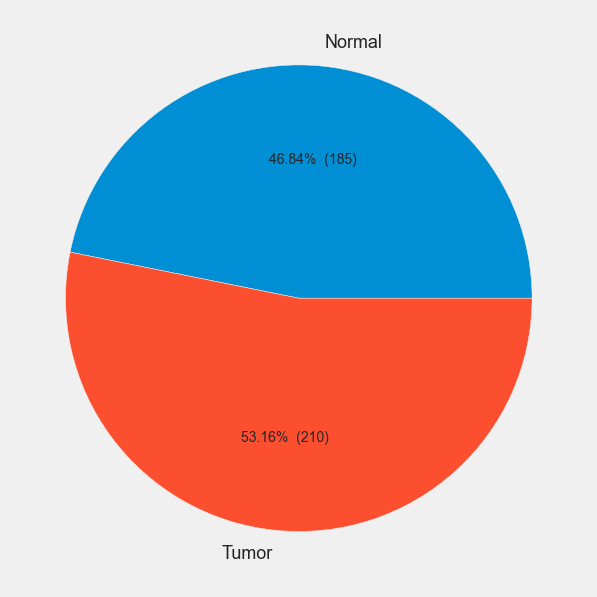

In [262]:
pie(samples2,'tissue_type')

In [263]:
# PCA
pcacoorfile = '../data/395_files_counts_pca_coors.txt'
counts_norm = counts.subtract(counts.mean()).divide(counts.std())
pca = PCA(n_components=6)
pca_coor = pca.fit_transform(counts_norm.transpose())
savetxt(pcacoorfile, pca_coor, delimiter=',') 
pca_coor.shape

(395, 6)

Text(0, 0.5, 'PC 2')

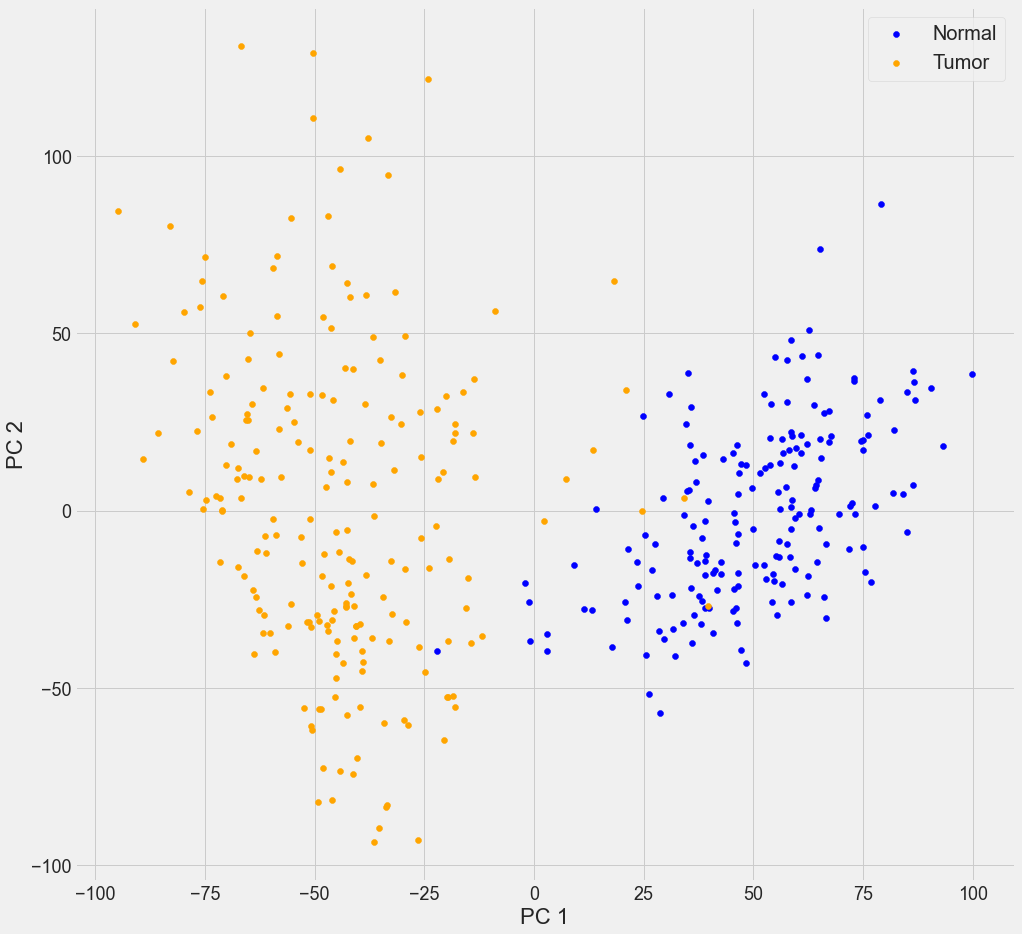

In [264]:
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

fig, ax = plt.subplots(figsize=(15,15))
labels = []
for l,c in zip(['Normal','Tumor'],['blue','orange']):
    inds = samples2[samples2['tissue_type']==l].index
    ax.scatter(pca_coor[inds, 0], pca_coor[inds, 1], label=l, color=c)
ax.legend(prop={'size': 20})
#ax.set_title(title,fontdict={'fontsize': 30, 'fontweight': 'medium'})
ax.set_xlabel('PC 1', fontdict={'fontsize': 22, 'fontweight': 'medium'})
ax.set_ylabel('PC 2', fontdict={'fontsize': 22, 'fontweight': 'medium'})


In [265]:
# only normal samples
samples3 = samples2[samples2['tissue_type']=='Normal']
counts = counts[list(samples3['file_uuids'])]
counts

,f20559be-0cc8-458b-b334-2ad0bb135445,fb21e40b-471d-4f53-bd98-0d2de2299060,f5271413-a40a-46a6-bb54-d5e5a66925af,...,70510e82-3d1e-4fb4-a2a1-7200bebcde16,7f0157b9-81cc-478a-9cd1-d734e8fa7584,897d7567-fc0b-466b-be8c-94f9df07b5bc
ENSG00000000003.13,813.0,687.0,727.0,...,561.0,960.0,1145.0
ENSG00000000005.5,12.0,13.0,4.0,...,14.0,12.0,8.0
ENSG00000000419.11,920.0,1433.0,965.0,...,906.0,773.0,1022.0
ENSG00000000457.12,1105.0,977.0,645.0,...,882.0,1210.0,965.0
ENSG00000000460.15,318.0,266.0,171.0,...,247.0,309.0,350.0
...,...,...,...,...,...,...,...
ENSG00000281910.1,0.0,0.0,1.0,...,0.0,0.0,0.0
ENSG00000281912.1,18.0,18.0,18.0,...,18.0,17.0,21.0
ENSG00000281918.1,25.0,18.0,18.0,...,16.0,23.0,14.0
ENSG00000281920.1,8.0,7.0,5.0,...,9.0,7.0,8.0


In [266]:
# Remove columns with information for less than 50% of the cases
missing_value_cutoff = 0.25

samples3 = samples3.loc[:,[x for x in list(samples3) if (
    len([y for y in samples3.loc[:,x] if y not in ["'--","Unknown",'Not Reported','not reported',np.nan]])>=
    (1-missing_value_cutoff)*len(samples3))]]

In [268]:
samples3.loc[:,['tissue_or_organ_of_origin']]

,tissue_or_organ_of_origin
0,"Lower lobe, lung"
3,"Lower lobe, lung"
4,"Lung, NOS"
7,"Lower lobe, lung"
9,"Lower lobe, lung"
...,...
383,"Lung, NOS"
386,"Middle lobe, lung"
387,"Lower lobe, lung"
390,"Lower lobe, lung"


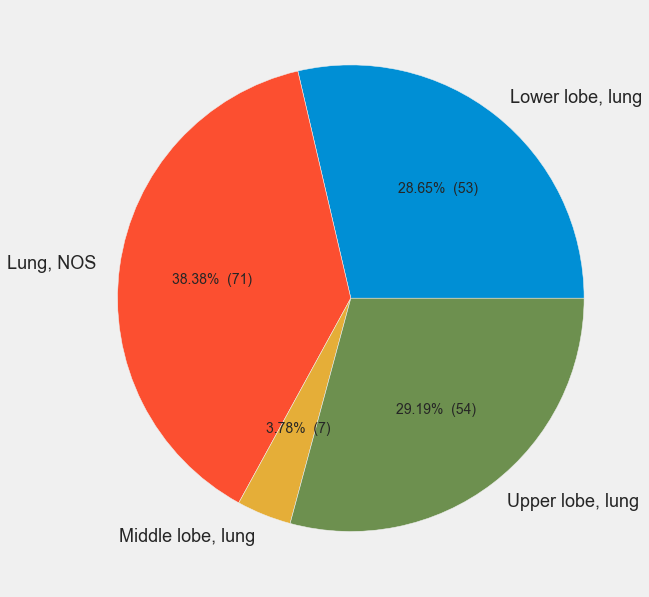

In [269]:
pie(samples3, 'tissue_or_organ_of_origin')

In [270]:
# Normalize to median count of sample
#counts_median_count = counts.divide(counts.sum()).multiply(counts.sum().median())

In [271]:
# Normalize to counts per million
counts_per_million = counts.divide(counts.sum()).multiply(1e6)

In [272]:
#counts_per_million_file = '../results/normal_samples_only/counts_per_million.txt'
#counts_per_million.to_csv(counts_per_million_file)

In [273]:
counts_per_million.sum()

f20559be-0cc8-458b-b334-2ad0bb135445    1000000.0
fb21e40b-471d-4f53-bd98-0d2de2299060    1000000.0
f5271413-a40a-46a6-bb54-d5e5a66925af    1000000.0
983a2345-9774-4d15-b7e8-67c38f8c1783    1000000.0
be380f56-a68a-41aa-8704-399a2c0d72e2    1000000.0
                                          ...    
3d0aabd6-55e9-426c-86a7-6a4a5c9272b0    1000000.0
7deba281-7163-4cbc-8f84-62302da3b09a    1000000.0
70510e82-3d1e-4fb4-a2a1-7200bebcde16    1000000.0
7f0157b9-81cc-478a-9cd1-d734e8fa7584    1000000.0
897d7567-fc0b-466b-be8c-94f9df07b5bc    1000000.0
Length: 185, dtype: float64

In [274]:
# Check genes that are differentialy expressed between current smokers and non-current smokers
# Two-sided Wilcoxon
'''
thrs = [0.01,0.05,0.1,0.15]
wilcoxon_table = pd.DataFrame(index=counts_per_million.index,
                             columns=['wrs','wrs_pvalue'])
smoking_uuids = samples3[samples3['tobacco_smoking_status']==2]['file_uuids']
nonsmoking_uuids = samples3[samples3['tobacco_smoking_status']!=2]['file_uuids']
for gene in wilcoxon_table.index:
    try:
        wilcoxon_table.loc[gene,'wrs'],wilcoxon_table.loc[gene,'wrs_pvalue'] = ranksums(
            counts_per_million.loc[gene,smoking_uuids],counts_per_million.loc[gene,nonsmoking_uuids])
    except:
        print(counts_per_million.loc[gene,smoking_uuids])
        print(counts_per_million.loc[gene,nonsmoking_uuids])
        wilcoxon_table.loc[gene,'wrs'],wilcoxon_table.loc[gene,'wrs_pvalue'] = [None,None]

wilcoxon_table = wilcoxon_table.sort_values(by='wrs_pvalue', ascending=True)

indss = [i for i in wilcoxon_table.index if not pd.isna(wilcoxon_table.loc[i,'wrs'])]
for thr in thrs:
    #python's fdrcorrection
    wilcoxon_table.loc[indss,'FDR_'+str(thr)],wilcoxon_table.loc[indss,'FDR_corrected_wrs_pvalue'] = fdrcorrection(
        wilcoxon_table.loc[indss,'wrs_pvalue'], alpha=thr, method='indep', is_sorted=True)

wilcoxon_table
'''

"\nthrs = [0.01,0.05,0.1,0.15]\nwilcoxon_table = pd.DataFrame(index=counts_per_million.index,\n                             columns=['wrs','wrs_pvalue'])\nsmoking_uuids = samples3[samples3['tobacco_smoking_status']==2]['file_uuids']\nnonsmoking_uuids = samples3[samples3['tobacco_smoking_status']!=2]['file_uuids']\nfor gene in wilcoxon_table.index:\n    try:\n        wilcoxon_table.loc[gene,'wrs'],wilcoxon_table.loc[gene,'wrs_pvalue'] = ranksums(\n            counts_per_million.loc[gene,smoking_uuids],counts_per_million.loc[gene,nonsmoking_uuids])\n    except:\n        print(counts_per_million.loc[gene,smoking_uuids])\n        print(counts_per_million.loc[gene,nonsmoking_uuids])\n        wilcoxon_table.loc[gene,'wrs'],wilcoxon_table.loc[gene,'wrs_pvalue'] = [None,None]\n\nwilcoxon_table = wilcoxon_table.sort_values(by='wrs_pvalue', ascending=True)\n\nindss = [i for i in wilcoxon_table.index if not pd.isna(wilcoxon_table.loc[i,'wrs'])]\nfor thr in thrs:\n    #python's fdrcorrection\n    

In [275]:
#wilcoxon_table = add_gene_names(wilcoxon_table)

In [11]:
wilcoxon_table_file = '../results/normal_samples_only/wilcoxon_smoking_status_2_vs_others.txt'
#wilcoxon_table.to_csv(wilcoxon_table_file)
wilcoxon_table = pd.read_csv(wilcoxon_table_file, index_col=0)
wilcoxon_table

,external_gene_name,wrs,wrs_pvalue,...,FDR_0.05,FDR_0.1,FDR_0.15
ENSG00000063438.15,AHRR,7.503560,6.210734e-14,...,True,True,True
ENSG00000171658.7,NMRAL2P,6.444234,1.161855e-10,...,True,True,True
ENSG00000131981.14,LGALS3,6.187946,6.095334e-10,...,True,True,True
ENSG00000154165.4,GPR15,5.923114,3.159015e-09,...,True,True,True
ENSG00000111863.11,ADTRP,5.769341,7.958215e-09,...,True,True,True
...,...,...,...,...,...,...,...
ENSG00000274649.1,AL512624.1,0.000000,1.000000e+00,...,False,False,False
ENSG00000254540.1,AC040936.1,0.000000,1.000000e+00,...,False,False,False
ENSG00000271671.1,AC107304.1,0.000000,1.000000e+00,...,False,False,False
ENSG00000221764.1,NaN,0.000000,1.000000e+00,...,False,False,False


In [277]:
diff_exp_genes = wilcoxon_table[wilcoxon_table['FDR_0.01']==True].index
wilcoxon_table.loc[diff_exp_genes,['external_gene_name',
                                     'wrs',
                                     'wrs_pvalue',
                                     'FDR_0.01',
                                     'FDR_corrected_wrs_pvalue']]

,external_gene_name,wrs,wrs_pvalue,FDR_0.01,FDR_corrected_wrs_pvalue
ENSG00000063438.15,AHRR,7.503560,6.210734e-14,True,3.587320e-09
ENSG00000171658.7,NMRAL2P,6.444234,1.161855e-10,True,3.355438e-06
ENSG00000131981.14,LGALS3,6.187946,6.095334e-10,True,1.173555e-05
ENSG00000154165.4,GPR15,5.923114,3.159015e-09,True,4.561618e-05
ENSG00000111863.11,ADTRP,5.769341,7.958215e-09,True,9.193330e-05
...,...,...,...,...,...
ENSG00000185985.8,SLITRK2,-3.969626,7.198568e-05,True,9.647084e-03
ENSG00000101265.14,RASSF2,-3.966778,7.285083e-05,True,9.740426e-03
ENSG00000115306.14,SPTBN1,-3.963930,7.372582e-05,True,9.811989e-03
ENSG00000125912.9,NCLN,3.963930,7.372582e-05,True,9.811989e-03


In [278]:
wilcoxon_table.loc[:,['external_gene_name',
                                     'wrs',
                                     'wrs_pvalue',
                                     'FDR_corrected_wrs_pvalue',
                     'FDR_0.01']].head(10)

,external_gene_name,wrs,wrs_pvalue,FDR_corrected_wrs_pvalue,FDR_0.01
ENSG00000063438.15,AHRR,7.503560,6.210734e-14,3.587320e-09,True
ENSG00000171658.7,NMRAL2P,6.444234,1.161855e-10,3.355438e-06,True
ENSG00000131981.14,LGALS3,6.187946,6.095334e-10,1.173555e-05,True
ENSG00000154165.4,GPR15,5.923114,3.159015e-09,4.561618e-05,True
ENSG00000111863.11,ADTRP,5.769341,7.958215e-09,9.193330e-05,True
ENSG00000069812.10,HES2,5.732321,9.906528e-09,9.536684e-05,True
ENSG00000197403.3,OR6N1,5.696726,1.221301e-08,1.007748e-04,True
ENSG00000143105.6,KCNA10,5.666826,1.454673e-08,1.050274e-04,True
ENSG00000154975.12,CA10,5.581396,2.385957e-08,1.400877e-04,True
ENSG00000138061.10,CYP1B1,5.578548,2.425341e-08,1.400877e-04,True


In [279]:
#counts_per_million_diff_genes = counts_per_million.loc[
#    [x for x in counts_per_million.index if x in diff_exp_genes],:]
#counts_per_million_diff_genes_file = '../results/normal_samples_only/counts_per_million_diff_genes.txt'
#counts_per_million_diff_genes.to_csv(counts_per_million_diff_genes_file)

In [280]:
#######################################################################################################

In [281]:
# Translate to gene symbols
'''
from gseapy.parser import Biomart

# prepare for conversion to gene symbols
bm = Biomart()
# view validated marts
marts = bm.get_marts()
# view validated dataset
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
# view validated attributes
attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl')
# view validated filters
filters = bm.get_filters(dataset='hsapiens_gene_ensembl')

# convert to gene symbols
# query results
target_list_symbols = bm.query(dataset='hsapiens_gene_ensembl',
                               attributes=['ensembl_gene_id', 'external_gene_name'],
                               filters={'ensembl_gene_id': [x[:x.find('.')] for x in wilcoxon_table.index]})
target_list_symbols.index = target_list_symbols['ensembl_gene_id']
target_list_symbols = target_list_symbols.drop('ensembl_gene_id', axis=1)
target_list_symbols.index.name = None
target_list_symbols
'''

"\nfrom gseapy.parser import Biomart\n\n# prepare for conversion to gene symbols\nbm = Biomart()\n# view validated marts\nmarts = bm.get_marts()\n# view validated dataset\ndatasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')\n# view validated attributes\nattrs = bm.get_attributes(dataset='hsapiens_gene_ensembl')\n# view validated filters\nfilters = bm.get_filters(dataset='hsapiens_gene_ensembl')\n\n# convert to gene symbols\n# query results\ntarget_list_symbols = bm.query(dataset='hsapiens_gene_ensembl',\n                               attributes=['ensembl_gene_id', 'external_gene_name'],\n                               filters={'ensembl_gene_id': [x[:x.find('.')] for x in wilcoxon_table.index]})\ntarget_list_symbols.index = target_list_symbols['ensembl_gene_id']\ntarget_list_symbols = target_list_symbols.drop('ensembl_gene_id', axis=1)\ntarget_list_symbols.index.name = None\ntarget_list_symbols\n"

In [282]:
target_list_symbols_file_name = 'hsapiens_gene_names.csv'
#target_list_symbols.to_csv(target_list_symbols_file_name)
target_list_symbols = pd.read_csv(target_list_symbols_file_name, index_col=0)
target_list_symbols

,external_gene_name
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1
...,...
ENSG00000171163,ZNF692
ENSG00000227237,AL672291.1
ENSG00000185220,PGBD2
ENSG00000200495,RNU6-1205P


In [283]:
#######################################################################################################

In [284]:
# feature table
features_table = pd.DataFrame(index=samples3.index,
                              columns=['age','gender','bmi',
                                      #'age_at_diagnosis',     # SAME AS AGE
                                       #'tumor_grade',
                                      'currently_smoking',
                                      #'smoking_degree',
                                      ])

features_table.loc[:,'age'] = np.around(samples3['days_to_birth']/(-365),1).astype(float)

features_table.loc[:,'gender'] = [0 if x=='male' else 1 for x in samples3['gender']]
features_table.loc[:,'gender'] = features_table.loc[:,'gender'].astype(bool)

features_table.loc[:,'bmi'] = samples3['bmi'].astype(float)

#features_table.loc[:,'age_at_diagnosis'] = np.around(samples2['age_at_diagnosis']/365).astype(float)

#normal_inds = samples2[samples2['tissue_type']=='Normal'].index
#tumor_inds = samples2[samples2['tissue_type']=='Tumor'].index
#features_table.loc[normal_inds,'tumor_grade'] = 0
#features_table.loc[tumor_inds,'tumor_grade'] = [s[1] for s in samples2.loc[tumor_inds,'tumor_grade']]

#features_table = features_table.merge(pd.get_dummies(samples2['primary_diagnosis']), how='left',
#                                      left_index=True, right_index=True)

features_table.loc[:,'currently_smoking'] = [1 if x==2 else 0 for x in samples3['tobacco_smoking_status']]
features_table.loc[:,'currently_smoking'] = features_table.loc[:,'currently_smoking'].astype(bool)

#smoking_dict = {1:1, 2:4, 3:2, 4:3, 5:3}
#features_table.loc[:,'smoking_degree'] = [smoking_dict[x] for x in samples2['tobacco_smoking_status']]

'''
# imputation
no_bmi_inds = features_table[features_table['bmi']=="'--"].index
bmi_inds = features_table[features_table['bmi']!="'--"].index
print(len(bmi_inds), 'patients with a bmi datum', len(no_bmi_inds), 'without')
features_table.loc[no_bmi_inds,'bmi'] = np.mean(features_table.loc[bmi_inds,'bmi'].astype(float))
features_table['bmi'] = features_table['bmi'].astype(float)
'''
#no_tumor_grade_inds = features_table[features_table['tumor_grade']=='X'].index
#features_table.loc[no_tumor_grade_inds,'tumor_grade'] = 2
#features_table['tumor_grade'] = features_table['tumor_grade'].astype(float)

features_table

,age,gender,bmi,currently_smoking
0,52.3,True,24.06,False
3,79.9,False,22.77,True
4,79.0,False,31.10,False
7,71.0,False,27.76,True
9,72.8,True,26.37,False
...,...,...,...,...
383,53.2,False,31.02,True
386,73.4,False,20.76,False
387,74.5,False,26.31,True
390,46.4,True,24.01,False


In [285]:
#features_table_file = '../results/normal_samples_only/features_table.txt'
#features_table.to_csv(features_table_file)

(array([45., 68., 44., 17.,  7.,  3.,  0.,  0.,  0.,  1.]),
 array([16.61 , 21.111, 25.612, 30.113, 34.614, 39.115, 43.616, 48.117,
        52.618, 57.119, 61.62 ]),
 <BarContainer object of 10 artists>)

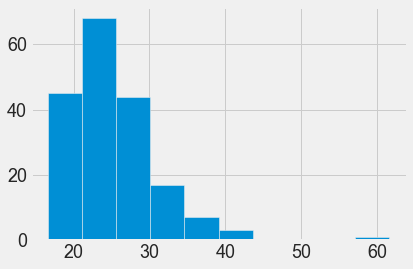

In [286]:
plt.hist(features_table['bmi'])

(array([ 1.,  5.,  8., 13., 40., 38., 44., 26.,  9.,  1.]),
 array([35.2 , 40.53, 45.86, 51.19, 56.52, 61.85, 67.18, 72.51, 77.84,
        83.17, 88.5 ]),
 <BarContainer object of 10 artists>)

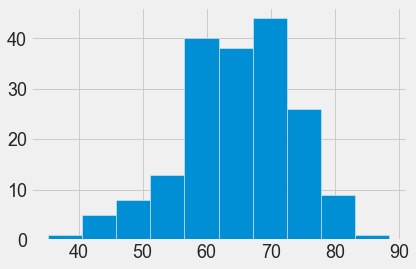

In [287]:
plt.hist(features_table['age'])

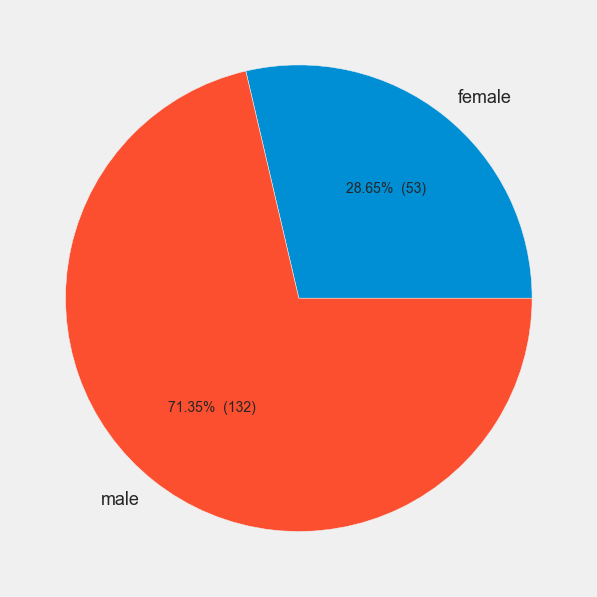

In [288]:
pie(samples3, 'gender')

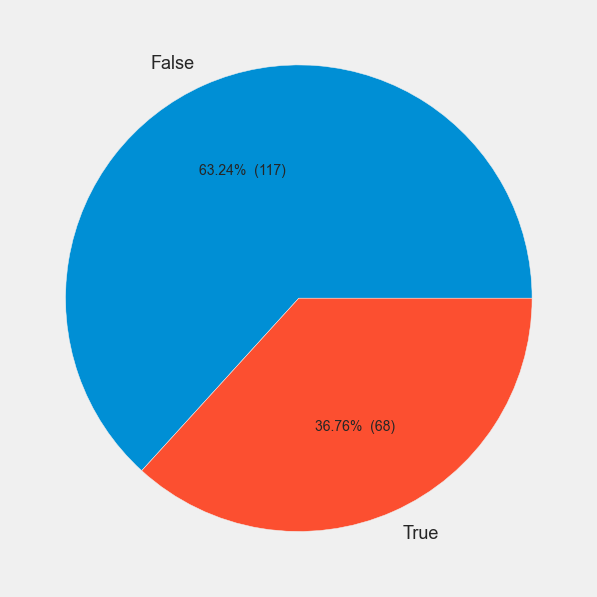

In [289]:
pie(features_table, 'currently_smoking')

In [290]:
# Remove the column of "Carcinoma, NOS"
#features_table = features_table.drop(['Carcinoma, NOS'], axis=1)
#features_table

In [291]:
list(features_table)

['age', 'gender', 'bmi', 'currently_smoking']

In [292]:
# Check Spearman correlation
'''
spearman_table = pd.DataFrame(index=counts_per_million.index)

for col in list(features_table):
    for gene in counts_per_million.index:
        spearman_table.loc[gene,col+'_corr'], spearman_table.loc[gene,col+'_pval'] = spearmanr(
            features_table.loc[:,col], counts_per_million.loc[gene,:])

for col in list(features_table):
    _,spearman_table.loc[:,col+'_pval_corrected'] = fdrcorrection(spearman_table.loc[:,col+'_pval'])
    
spearman_table = spearman_table[sorted(list(spearman_table))]

spearman_table
'''

"\nspearman_table = pd.DataFrame(index=counts_per_million.index)\n\nfor col in list(features_table):\n    for gene in counts_per_million.index:\n        spearman_table.loc[gene,col+'_corr'], spearman_table.loc[gene,col+'_pval'] = spearmanr(\n            features_table.loc[:,col], counts_per_million.loc[gene,:])\n\nfor col in list(features_table):\n    _,spearman_table.loc[:,col+'_pval_corrected'] = fdrcorrection(spearman_table.loc[:,col+'_pval'])\n    \nspearman_table = spearman_table[sorted(list(spearman_table))]\n\nspearman_table\n"